# Predicting *sentimental impact*

For this project, we decided to try and predict the *sentimental impact* certain conflicts have in other countries. Bear in mind what you are about to read is but a sequel to the [project's root README](https://github.com/nunomota/ada2017-hw/blob/master/project/README.md) - so that we can keep information duplication to a bare minimum.

Although it may seem quite complicated, this end goal can be broken down into smaller steps:

1. [Language Recognition](https://github.com/nunomota/ada2017-hw/blob/master/project/scripts/language_recognition.py): To identify and keep only English Tweets

2. [Named Entity Recognition](https://github.com/nunomota/ada2017-hw/blob/master/project/scripts/name_entity_recognition.py): To find which country a Tweet might be referring to

3. [Sentiment Analysis](https://github.com/nunomota/ada2017-hw/blob/master/project/scripts/sentiment_analysis.py): To measure the sentiment associated with a Tweet

4. Location and textual data: Taken from UCDP and Twitter datasets

**Note:** To keep the code clear and concise, we moved the code related to these steps into separate scripts. For the most part, this notebook covers a higher level of the implementation - if you would like to know more about the specifics, everything is properly commented within each script.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Add scripts folder to path
import sys
sys.path.append('scripts')

# Get Tweets
import pandas as pd
TWEET_SAMPLE_FILE_PATH = 'data/parsed/markov_text_files/tweet_sentiment_sample.csv'
tweets_df = pd.read_csv(TWEET_SAMPLE_FILE_PATH, index_col=False, compression='gzip', encoding='utf-8')

Tweet sample:

In [2]:
tweets_df.head()

,Text
0,This Kutuzov who before the battle of Borodino...
1,"Djibouti The economy is based on agriculture, ..."
2,Le gouvernement français a voté une loi qui in...
3,Crude oil and natural gas and holds more than ...
4,Sandokan ist eine imaginäre Figur und Protagon...


## Language Recognition (LR)

The [language recognition script](https://github.com/nunomota/ada2017-hw/blob/master/project/scripts/language_recognition.py) makes use of the [langdetect library](https://pypi.python.org/pypi/langdetect) to output whether or not a certain Tweet is written in English. Although this library's reliability increases with the text's length - and hence a bit limited for Tweets - it tends to give more *false negatives* than *false positives*. This is not a problem since we have a large amount of data and we would rather discard some English Tweets than keeping others in foreign languages.

In [3]:
import language_recognition as lr

Examples of application of the *language recognition* over different samples:

In [4]:
def color_formatting(result):
    if result:
        return("\x1b[32m {}  \x1b[0m".format(result))
    
    return("\x1b[31m {} \x1b[0m".format(result))

In [5]:
# Example written in english
english_example = 'Portuguese people always arrive late'

# Example written in French
french_example = 'Les Portugais arrivent toujours en retard'

# Example written in French
german_example = 'Portugiesen kommen immer zu spät'

print("\n ---- LANGUAGE RECOGNITION EXAMPLE")
print("|")
print("| {} :  \"{}\"".format(color_formatting(lr.is_tweet_english(english_example)), english_example))
print("|")
print("| {} :  \"{}\"".format(color_formatting(lr.is_tweet_english(french_example)), french_example))
print("|")
print("| {} :  \"{}\"".format(color_formatting(lr.is_tweet_english(german_example)), german_example))
print("|")
print(" ----")


 ---- LANGUAGE RECOGNITION EXAMPLE
|
|  True   :  "Portuguese people always arrive late"
|
|  False  :  "Les Portugais arrivent toujours en retard"
|
|  False  :  "Portugiesen kommen immer zu spät"
|
 ----


### Applying to Tweets:
We can now use this module to filter out all the Tweets that are not English

In [6]:
tweets_df = tweets_df[tweets_df['Text'].apply(lambda x: lr.is_tweet_english(x))]

Sample:

In [7]:
tweets_df.head()

,Text
0,This Kutuzov who before the battle of Borodino...
1,"Djibouti The economy is based on agriculture, ..."
3,Crude oil and natural gas and holds more than ...
5,Economic growth gained momentum in 2004 and th...
6,Gabon Gabon enjoys a per capita income roughly...


## Named Entity Recognition (NER)

This is the trickiest part of the project. The main goal is to find whether or not a Tweet is talking about a country. For this part, we opted to use a natural language processing library called [Spacy](https://spacy.io/), for a couple of reasons:

1. Simple text comparison tends to over-identify entities in a text (loose words might match but, contextually, they might not be referring to a place)
2. Other alternatives, like [NLTK](http://www.nltk.org/) tended to be slower
3. Spacy comes with built-in models trained with [OntoNotes 5](https://catalog.ldc.upenn.edu/ldc2013t19), giving us a wide range of entity labels to work with

Although it seems to work quite well, we noticed many cases where it may (or not) consider certain entities based on their capitalization alone. To minimize these errors, we created a [Tweet Generator](https://github.com/nunomota/ada2017-hw/blob/master/project/analyzers/Auxiliary/tweets_generator.ipynb). This notebook creates Markov Chains models by analysing several corpus we provide (stories, geo-political or religious texts, news, etc...) and, through the [markovify library](https://github.com/jsvine/markovify), it generates several texts with specified length (in this case 140, which is a Tweet's max length). The aim is to, as a next step, go through its interactive generator and manually specify what we find in the generated text. From the overall output of that process we expect to find which text-formatting techniques provide a higher accuracy for our NER model (e.g. lower-case text for cities, upper-case for countries or title-case for religions).

We also enriched our data with many other datasets (also specified in the [project's root README](https://github.com/nunomota/ada2017-hw/blob/master/project/README.md)), creating bi-lateral associations between:

* Countries
* Cities
* Nationalities
* Religions
* Religious affiliations
* Currencies

Also, we don't just keep Tweets that directly refer to a country. In the context of *religions*, *cities* and *currencies* there are a lot of possible countries related to a single word (e.g. several countries might have a city with the same name). In these cases, we take into account the probability each entity is referring to each country. We then take all of the entities, analyze the probabilities and find which are the *most likely* countries. If a country is within that set of values and its probability is above a certain threshold, we assume the Tweet is referring to it.

In [8]:
import name_entity_recognition as ner

# Load the necessary data for the module
ner.load_data()

Examples of application of the *named entity recognition* over different samples:

In [9]:
# Examples
country_examples = ['"People from Portugal always arrive late"',
                    '"In Sweden, people that always arrive late are not appreciated"',
                    '"Portugal and Zimbabwe are facing each other during tonight\'s footbal match"',
                    '"I have lived in Lausanne for a year without going back to Portugal"',
                    '"I like to play tennis"']

city_examples = ['"My train for Milan arrived so late I missed the last bus to go home"',
                 '"In Lisbon, people always arrive late"',
                 '"My spanish friend visited Lisbon !"',
                 '"The capital of Portugal is not Bern"',
                 '"I have lived in China all my life, but I was born in Lisbon" (1)']

nationalities_examples = ['"Portuguese people always arrive late"',
                          '"I know a very good Sino - Portuguese restaurant that makes food from Macau" (2)',
                          '"Both german and french love to spend their vacation in Lisbon"',
                          '"Italians usually prefer to find a job in Switzerland"',
                          '"Europeans have been shocked by the UK decision on leaving the union"']

currency_examples = ['"Payments in euro always arrive late"',
                     '"Portugal is part of the euro zone"']

religion_examples = ['More than 80% of Portuguese are catholic']


examples = {'COUNTRY':country_examples, 'CITY':city_examples, 'NATIONALITY':nationalities_examples, 
            'CURRENCY': currency_examples, 'RELIGION':religion_examples}

# Output printing
print("\n ---- NAMED ENTITY RECOGNITION EXAMPLE")
for key in examples:
    print("|\n|\n ---- {}".format(key))
    for e in examples[key]:
        print("|\n| {} :  {}".format(color_formatting(ner.is_tweet_about_country(e, 'PT')), e))
        
print("|\n ----\n\n")


 ---- NAMED ENTITY RECOGNITION EXAMPLE
|
|
 ---- COUNTRY
|
|  True   :  "People from Portugal always arrive late"
|
|  False  :  "In Sweden, people that always arrive late are not appreciated"
|
|  True   :  "Portugal and Zimbabwe are facing each other during tonight's footbal match"
|
|  True   :  "I have lived in Lausanne for a year without going back to Portugal"
|
|  False  :  "I like to play tennis"
|
|
 ---- CITY
|
|  False  :  "My train for Milan arrived so late I missed the last bus to go home"
|
|  False  :  "In Lisbon, people always arrive late"
|
|  True   :  "My spanish friend visited Lisbon !"
|
|  True   :  "The capital of Portugal is not Bern"
|
|  False  :  "I have lived in China all my life, but I was born in Lisbon" (1)
|
|
 ---- NATIONALITY
|
|  True   :  "Portuguese people always arrive late"
|
|  False  :  "I know a very good Sino - Portuguese restaurant that makes food from Macau" (2)
|
|  True   :  "Both german and french love to spend their vacation in Lisbon"


The different examples above of application of NER illustrate the functioning of the Script. Although, one could find a couple of interesting results we have numbered and we will discuss hereby.

**(1)** One could expect that the sample tweet "*I have lived in China all my life, but I was born in Lisbon*" should clearly talk about Portugal has its capital Lisbon is evidenced. Although, the NER result is False.

In order to comment on this result, one has to understand how it is obtained. During the identification of the different special words the NER script it finds in the sentence ("*China*", "*Lisbon*), a propapility is assigned giving a weight to a related country. This dictionary of plobabilities for each country is obtained as follows:

In [10]:
tweet = 'I have lived in China all my life, but I was born in Lisbon'

print("{} :  {}".format(color_formatting(ner.is_tweet_about_country(tweet, 'PT')), tweet))
print("\t\t| \n\t\t|-> {}".format(ner.get_countries_from_content(tweet)) )

 False  :  I have lived in China all my life, but I was born in Lisbon
		| 
		|-> {'CN': 0.5, 'US': 0.25, 'PT': 0.25}


Although we expected to have, at worst, a 50-50 probability of China and Portugal (that would have passed the threashold). But apparently the Portugal only gets 25% as it splits it with the US. This is a tricky example, 'cause the NER script seems not working correctly while it is actually performing fine given the existence of a city in the US called Lisbon too most of us don't think of.

One can toggle the probabilities weights by simply altering the tweet to remove any uncertainties:

In [11]:
tweet = 'I have lived in China all my life, but I was born in Lisbon, Portugal'

print("{} :  {}".format(color_formatting(ner.is_tweet_about_country(tweet, 'PT')), tweet))
print("\t\t| \n\t\t|-> {}".format(ner.get_countries_from_content(tweet)) )

 True   :  I have lived in China all my life, but I was born in Lisbon, Portugal
		| 
		|-> {'CN': 0.3333333333333333, 'US': 0.16666666666666666, 'PT': 0.5}


<br>
**(2)** The sample tweet "*I know a very good Sino - Portuguese restaurant that makes food from Macau*" could have up to three labeled country ("*Sino*" = China, "*Portuguese*" = Portugal, "*Macau*" = Macau special Region). Even though we accept the fact that "Sino" might be very tricky and it could be difficult for a NER to identify the connection to China, it would still leave us with a 50-50 probability between Portugal and Macau (enough for the accepting threashold)

We can see the actual dictionary of probabilities once again:

In [12]:
tweet = 'I know a very good Sino - Portuguese restaurant that makes food from Macau'

print("{} :  {}".format(color_formatting(ner.is_tweet_about_country(tweet, 'PT')), tweet))
print("\t\t| \n\t\t|-> {}".format(ner.get_countries_from_content(tweet)) )

 False  :  I know a very good Sino - Portuguese restaurant that makes food from Macau
		| 
		|-> {'MO': 1.0}


The result illustrates a full 100% probability for Macau (code "MO"), without getting in Portugal in consideration. This is a clear example of the manifestation of a **False Positive**. During our analysis, we have encountered cases in which the NER analysis happened to miss certain labels during the handling of the text. 

Although, as seen in the multiple examples and in the in-depth analysis, such case could not be considered as harsh, it is important to keep it in mind as part of the controversial results context.

### Applying to Tweets
We can now find out which countries the Tweets are talking about

In [13]:
tweets_df['Countries'] = tweets_df['Text'].apply(lambda x: ner.get_countries_from_content(x).keys())

Sample:

In [14]:
tweets_df.head()

,Text,Countries
0,This Kutuzov who before the battle of Borodino...,"(RU, UA)"
1,"Djibouti The economy is based on agriculture, ...","(DJ, IN)"
3,Crude oil and natural gas and holds more than ...,()
5,Economic growth gained momentum in 2004 and th...,()
6,Gabon Gabon enjoys a per capita income roughly...,"(GA, DE, FR)"


## Sentiment Analysis (SA)

The [sentiment analysis script](https://github.com/nunomota/ada2017-hw/blob/master/project/scripts/sentiment_analysis.py) depends on [NLTK's Vader](http://www.nltk.org/_modules/nltk/sentiment/vader.html) sentiment analyzer. From the final result of this library, we then return the *compound* value (which already takes into account the *positive*, *negative* and *neutral* sentiments in the text) and will be within the range [-1.0, 1.0].

In [15]:
import sentiment_analysis as sa

Examples of application of the *sentiment analysis* over different samples:

In [16]:
def color_formatting_number(result):
    if result > 0:
        return("\x1b[32m {}  \x1b[0m".format(result))
    
    if result < 0:
        return("\x1b[31m {} \x1b[0m".format(result))
    
    return(" {}     ".format(result))

In [17]:
# Examples with different grades of sentiment
positive_example = 'It\'s weird, but I EXTREMELY love that Portuguese people always arrive late'
not_so_positive_example = 'I am ok with Portuguese people that always arrive late'
normal_example = 'Portuguese people always arrive late'
not_so_negative_example = 'I don\'t really like Portuguese people because they always arrive late'
negative_example = 'I hate that that Portuguese people always arrive late'

print("\n ---- SENTIMENT ANALYSIS EXAMPLE")
print("|")
print("| {} :  \"{}\"".format(color_formatting_number(sa.get_sentiment_intensity(positive_example)), positive_example))
print("|")
print("| {}  :  \"{}\"".format(color_formatting_number(sa.get_sentiment_intensity(not_so_positive_example)), not_so_positive_example))
print("|")
print("| {} :  \"{}\"".format(color_formatting_number(sa.get_sentiment_intensity(normal_example)), normal_example))
print("|")
print("| {} :  \"{}\"".format(color_formatting_number(sa.get_sentiment_intensity(not_so_negative_example)), not_so_negative_example))
print("|")
print("| {} :  \"{}\"".format(color_formatting_number(sa.get_sentiment_intensity(negative_example)), negative_example))
print("|")
print(" ----")


 ---- SENTIMENT ANALYSIS EXAMPLE
|
|  0.8397   :  "It's weird, but I EXTREMELY love that Portuguese people always arrive late"
|
|  0.296    :  "I am ok with Portuguese people that always arrive late"
|
|  0.0      :  "Portuguese people always arrive late"
|
|  -0.3241  :  "I don't really like Portuguese people because they always arrive late"
|
|  -0.5719  :  "I hate that that Portuguese people always arrive late"
|
 ----


### Applying to Tweets
We will now proceed to analyze the sentiments on our dataset

In [18]:
tweets_df['Sentiment'] = tweets_df['Text'].apply(lambda x: sa.get_sentiment_intensity(x))

Sample:

In [19]:
tweets_df.head()

,Text,Countries,Sentiment
0,This Kutuzov who before the battle of Borodino...,"(RU, UA)",-0.7964
1,"Djibouti The economy is based on agriculture, ...","(DJ, IN)",0.0000
3,Crude oil and natural gas and holds more than ...,(),-0.2960
5,Economic growth gained momentum in 2004 and th...,(),0.6369
6,Gabon Gabon enjoys a per capita income roughly...,"(GA, DE, FR)",0.5106


## Sentimental impact

Our purpose on this notebook is to group the Tweets we found (based on their *Sentiment Strength*) and simulate a chronological order over a time-frame. Then step after is calculating the daily *Sentiment Strength* for those time-frames - making sure we penalize outliers, to avoid considering random over-emotional Tweets.

To define *sentimental impact*, at last, we analyse the contrast between the *before* and *after* of the daily sentimental strengths (not penalizing outliers, since one-day conflicts might have an emotional peak for a single day and they still might be as *emotionaly impactful* as a weekly conflict).

We include two examples to show this functionality.

#### Daily sentiment measurement

We use the median-absolute deviation to identify the outliers and we then compute the truncated mean ignoring those outliers. This function has been implemented based on (1). The following example computes the sentiment for a set that follows a normal distribution, hence we expect to obtain a _neutral_ result - with a value close to 0.

(1) Iglewicz, Boris, and David Hoaglin. _Volume 16: how to detect and handle outliers, The ASQC basic references in quality control: statistical techniques, Edward F. Mykytka_. Diss. Ph. D., Editor, 1993.

In [20]:
import sentiment_impact as si

np.random.seed(50)
a = np.random.normal(size=2000)
a = a/max(abs(a))
print('The sentiment is {}'.format(si.overall_sentiment(a)))

The sentiment is 0.032897981536937126


#### Sentimental impact estimation

After having obtained the sentiment measures we can obtain an estimation for the sentimental impact. For this we implemented a function that receives an array of overall sentiments computed daily for a certain timeframe centered on the conflict date.
It returns the impact of the conflict by comparing the changes in sentiment that take place before and after a conflict date.

It returns a value in the range [0.0, 1.0] and it does not penalize how long it takes for the average sentiment to change, since we would like to have some margin that accounts for the difference between timezones.

The following example has been obtained for the case where a previously _neutral_ sentiment turned into a positive one after the conflict date:

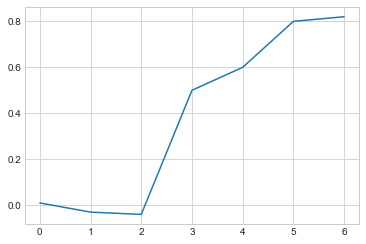

The sentiment impact is 0.13499999999999998


In [21]:
from sentiment_impact import measure_impact
ex0 = np.array([.01,-.03,-.04,.5,.6,.8,.82])
plt.plot(range(len(ex0)), ex0)
plt.show()
print('The sentiment impact is {}'.format(measure_impact(ex0)))

## Next steps

Although we already extracted the information we need from the UCDP dataset, we didn't do it yet with the Twitter one. Since we didn't have access to it from the start, we decided to focus on the above topics in the mean time - using a local, smaller dataset. Because of this, our next steps will be:

1. Categorize conflicts (e.g. according to casualties)
2. Filter Tweets that are within 3 days (before and after) each of the conflicts' start dates
3. Filter Tweets with *LR* and *NER* 
4. Apply *SA* on the remaining Tweets and calculate *sentimental impact*
5. Train a machine learning model that uses *conflict category* and *conflict country* as features and tries to predict *sentiment impact*
6. Show predictions accross countries for same-category conflicts

## Methodological pipeline

#### 1. Read tweets for a certain timeframe

In [22]:
tweets_df = pd.read_csv("tweets_sample.csv", index_col=False, compression='gzip', encoding='utf-8')
tweets_df

,Text,Date
0,No estoy de acuerdo con los que solo se preocu...,2017-11-13
1,I loved visiting Paris! Thank you to everyone ...,2017-11-12
2,It's freezing in Stockholm atm.. This weather ...,2017-11-12
3,Does anyone have a tent I can borrow? i'm SUPE...,2017-11-12
4,The heartbreaking news... Thoughts and Prayers...,2017-11-14
5,Paris relembra os dois anos dos atentados terr...,2017-11-14
6,"Silence, respect, prayers, tears... RIP for Pa...",2017-11-13
7,Israel benefits from each and every terror act...,2017-11-14
8,They know how to pay attention to Paris Attack...,2017-11-14
9,It's been almost 1 year since Paris Attack. Th...,2017-11-14


#### 2. Filter by language to keep tweets in English

In [23]:
tweets_df = tweets_df[tweets_df['Text'].apply(lambda x: lr.is_tweet_english(x))]
tweets_df

,Text,Date
1,I loved visiting Paris! Thank you to everyone ...,2017-11-12
2,It's freezing in Stockholm atm.. This weather ...,2017-11-12
3,Does anyone have a tent I can borrow? i'm SUPE...,2017-11-12
4,The heartbreaking news... Thoughts and Prayers...,2017-11-14
6,"Silence, respect, prayers, tears... RIP for Pa...",2017-11-13
7,Israel benefits from each and every terror act...,2017-11-14
8,They know how to pay attention to Paris Attack...,2017-11-14
9,It's been almost 1 year since Paris Attack. Th...,2017-11-14


#### 3. Apply NER to find tweets about France

In [24]:
tweets_df = tweets_df[tweets_df['Text'].apply(lambda x: ner.is_tweet_about_country(x, 'FR'))]
tweets_df

,Text,Date
1,I loved visiting Paris! Thank you to everyone ...,2017-11-12
3,Does anyone have a tent I can borrow? i'm SUPE...,2017-11-12
4,The heartbreaking news... Thoughts and Prayers...,2017-11-14
6,"Silence, respect, prayers, tears... RIP for Pa...",2017-11-13
9,It's been almost 1 year since Paris Attack. Th...,2017-11-14


#### 4. Carry out sentiment analysis

In [25]:
tweets_df['Sentiment'] = tweets_df['Text'].apply(lambda x: sa.get_sentiment_intensity(x))
tweets_df

/home/lucia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Text,Date,Sentiment
1,I loved visiting Paris! Thank you to everyone ...,2017-11-12,0.9039
3,Does anyone have a tent I can borrow? i'm SUPE...,2017-11-12,0.8087
4,The heartbreaking news... Thoughts and Prayers...,2017-11-14,-0.4588
6,"Silence, respect, prayers, tears... RIP for Pa...",2017-11-13,0.2023
9,It's been almost 1 year since Paris Attack. Th...,2017-11-14,-0.3182


#### 5. Measure sentimental impact

We first obtain the daily average sentiments

In [26]:
before = np.array(tweets_df[tweets_df['Date'] == "2017-11-12"]['Sentiment'])
during = np.array(tweets_df[tweets_df['Date'] == "2017-11-13"]['Sentiment'])
after = np.array(tweets_df[tweets_df['Date'] == "2017-11-14"]['Sentiment'])

In [27]:
before_sentiment = si.overall_sentiment(before)
during_sentiment = si.overall_sentiment(during)
after_sentiment = si.overall_sentiment(after)

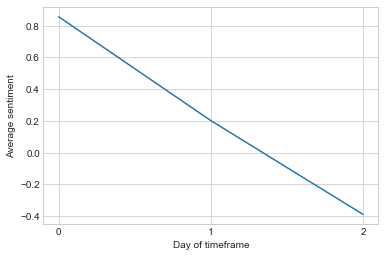

In [38]:
timeframe = [before_sentiment, during_sentiment, after_sentiment]
plt.plot(timeframe)
plt.xticks([0,1,2])
plt.xlabel('Day of timeframe')
plt.ylabel('Average sentiment')
plt.show() 

And then compute the sentimental impact

In [39]:
measure_impact(timeframe)

0.2954